In [1]:
import sys

sys.path.append('../..') # Add backtester base dir to $PYTHONPATH

In [2]:
%config InlineBackend.figure_format="retina"
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

In [3]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest

In [3]:
# Cleaned up data
data = HistoricalOptionsData("allspx/options_data_v2_pruned_compressed.h5", key="/SPX")
schema = data.schema

In [4]:
data._data = data._data[(data._data['quotedate'] >= '2006-12-06') & (data._data['quotedate'] <= '2015-08-21')]

We run the backtest on the date range above to compare with [this backtest.](http://dtr-trading.blogspot.com/p/spx-straddle-articles.html) We do the comparison with a [short (ATM) straddle](https://www.investopedia.com/terms/s/shortstraddle.asp) 45 DTE. Essentially the strategy consists of selling both a call and a put with (approximately) the same strike and expiration date, profiting if the underlying asset's price does not move very much. 

In [5]:
# Short ATM straddle
short_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 2)

short_straddle.add_legs([leg1, leg2])
# Exit thresholds: we exit if the loss or profit on the investment on an entry is greater than 25%.
short_straddle.exit_thresholds = (0.25, 0.25)

In [6]:
bt = Backtest(capital = 0)
bt.strategy = short_straddle
bt.data = data
bt.stop_if_broke = False

In [7]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:52


leg_1                                               \
                contract underlying expiration  type  strike     cost   
0     SXZ070120C01435000        SPX 2007-01-20  call  1435.0  -1110.0   
1     SXZ070120C01440000        SPX 2007-01-20  call  1440.0   -840.0   
2     SXZ070120C01450000        SPX 2007-01-20  call  1450.0   -520.0   
3     SXZ070120C01455000        SPX 2007-01-20  call  1455.0   -410.0   
4     SXZ070120C01455000        SPX 2007-01-20  call  1455.0    400.0   
...                  ...        ...        ...   ...     ...      ...   
1329  SPX150821C01975000        SPX 2015-08-21  call  1975.0  10390.0   
1330  SPX150821C01965000        SPX 2015-08-21  call  1965.0  11390.0   
1331  SPX150821C01980000        SPX 2015-08-21  call  1980.0   9890.0   
1332  SPX150821C01985000        SPX 2015-08-21  call  1985.0   9390.0   
1333  SPX150918C02005000        SPX 2015-09-18  call  2005.0   5680.0   

                                    leg_2                                     \
           date order            contract underlying expiration type  strike   
0    2006-12-06   STO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
1    2006-12-07   STO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2    2006-12-08   STO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3    2006-12-11   STO  SXY070120P01365000        SPX 2007-01-20  put  1365.0   
4    2006-12-18   BTC  SXY070120P01365000        SPX 2007-01-20  put  1365.0   
...         ...   ...                 ...        ...        ...  ...     ...   
1329 2015-08-19   BTC  SPX150821P01975000        SPX 2015-08-21  put  1975.0   
1330 2015-08-19   BTC  SPX150821P01965000        SPX 2015-08-21  put  1965.0   
1331 2015-08-19   BTC  SPX150821P01980000        SPX 2015-08-21  put  1980.0   
1332 2015-08-19   BTC  SPX150821P01985000        SPX 2015-08-21  put  1985.0   
1333 2015-08-20   BTC  SPX150918P02015000        SPX 2015-09-18  put  2015.0   

                                totals  
        cost       date order     cost  
0     -460.0 2006-12-06   STO  -1570.0  
1     -480.0 2006-12-07   STO  -1320.0  
2     -460.0 2006-12-08   STO   -980.0  
3     -580.0 2006-12-11   STO   -990.0  
4      340.0 2006-12-18   BTC    740.0  
...      ...        ...   ...      ...  
1329    20.0 2015-08-19   BTC  10410.0  
1330    20.0 2015-08-19   BTC  11410.0  
1331    20.0 2015-08-19   BTC   9910.0  
1332    25.0 2015-08-19   BTC   9415.0  
1333  3460.0 2015-08-20   BTC   9140.0  

[1334 rows x 17 columns]

/Users/jrchatruc/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


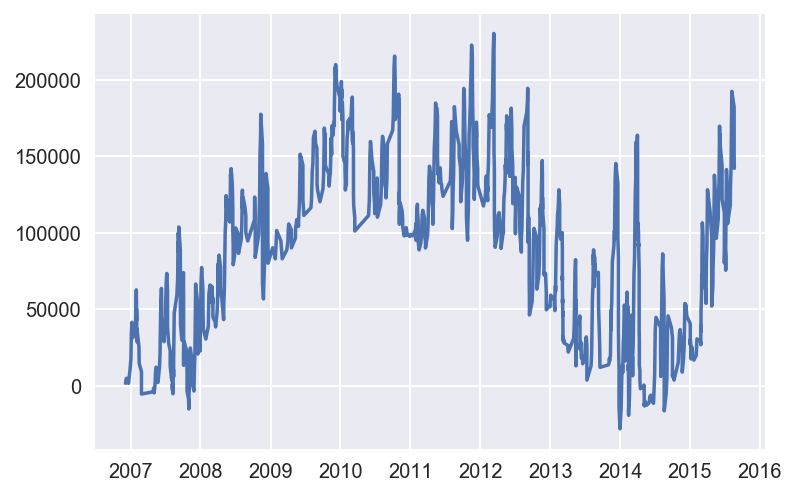

In [8]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

We now run a [long (ATM) straddle](https://www.investopedia.com/terms/l/longstraddle.asp) 45 DTE. This is the opposite of the previous strategy, where we enter buying the contracts instead of selling, and therefore profit from big movements in the underlying asset's price. 

In [9]:
# Long (ATM) straddle
long_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg2.exit_filter = (schema.dte <= 2)

long_straddle.add_legs([leg1, leg2])
long_straddle.exit_thresholds = (0.25, 0.25)

In [10]:
bt = Backtest(capital = 0)
bt.strategy = long_straddle
bt.data = data
bt.stop_if_broke = False

In [11]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:02:43


leg_1                                               \
                contract underlying expiration  type  strike     cost   
0     SXZ070120C01435000        SPX 2007-01-20  call  1435.0   1230.0   
1     SXZ070120C01440000        SPX 2007-01-20  call  1440.0    930.0   
2     SXZ070120C01450000        SPX 2007-01-20  call  1450.0    570.0   
3     SXZ070120C01455000        SPX 2007-01-20  call  1455.0    480.0   
4     SXZ070120C01435000        SPX 2007-01-20  call  1435.0   -910.0   
...                  ...        ...        ...   ...     ...      ...   
1326  SPX150918C01975000        SPX 2015-09-18  call  1975.0  11190.0   
1327  SPX150821C01965000        SPX 2015-08-21  call  1965.0 -10830.0   
1328  SPX150821C01955000        SPX 2015-08-21  call  1955.0 -11830.0   
1329  SPX150918C02005000        SPX 2015-09-18  call  2005.0  -5460.0   
1330  SPX150918C02000000        SPX 2015-09-18  call  2000.0  -5810.0   

                                    leg_2                                     \
           date order            contract underlying expiration type  strike   
0    2006-12-06   BTO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
1    2006-12-07   BTO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2    2006-12-08   BTO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3    2006-12-11   BTO  SXY070120P01365000        SPX 2007-01-20  put  1365.0   
4    2006-12-12   STC  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
...         ...   ...                 ...        ...        ...  ...     ...   
1326 2015-08-07   BTO  SPX150918P02045000        SPX 2015-09-18  put  2045.0   
1327 2015-08-19   STC  SPX150821P01965000        SPX 2015-08-21  put  1965.0   
1328 2015-08-19   STC  SPX150821P01955000        SPX 2015-08-21  put  1955.0   
1329 2015-08-20   STC  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
1330 2015-08-20   STC  SPX150918P02020000        SPX 2015-09-18  put  2020.0   

                                totals  
        cost       date order     cost  
0      550.0 2006-12-06   BTO   1780.0  
1      570.0 2006-12-07   BTO   1500.0  
2      550.0 2006-12-08   BTO   1120.0  
3      620.0 2006-12-11   BTO   1100.0  
4     -420.0 2006-12-12   STC  -1330.0  
...      ...        ...   ...      ...  
1326  2720.0 2015-08-07   BTO  13910.0  
1327   -10.0 2015-08-19   STC -10840.0  
1328    -5.0 2015-08-19   STC -11835.0  
1329 -3270.0 2015-08-20   STC  -8730.0  
1330 -3410.0 2015-08-20   STC  -9220.0  

[1331 rows x 17 columns]

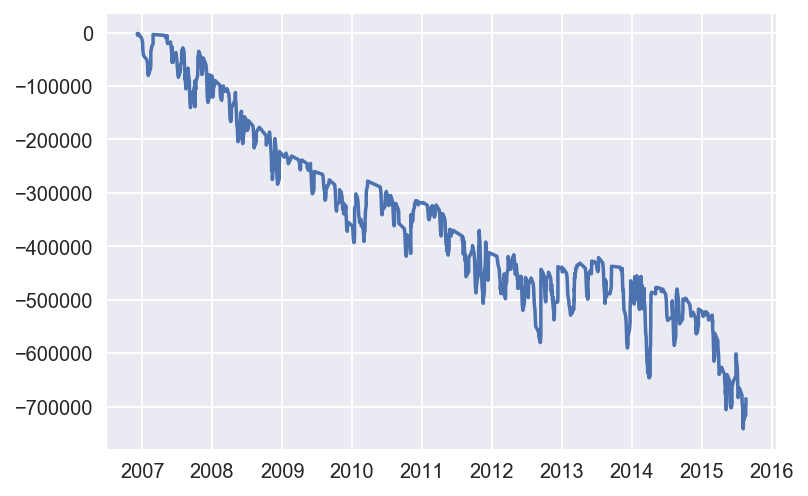

In [12]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

Finally we run an [iron condor](https://www.investopedia.com/terms/i/ironcondor.asp).

In [13]:
# Iron Condor
iron_condor = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.PUT, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= 0.85 * schema.underlying_last)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 0.90 * schema.underlying_last) & (schema.strike <= schema.underlying_last)
leg2.exit_filter = (schema.dte <= 2)

leg3 = StrategyLeg("leg_3", schema, option_type=Type.CALL, direction=Direction.SELL)
leg3.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= schema.underlying_last) & (schema.strike <= 1.10 * schema.underlying_last)
leg3.exit_filter = (schema.dte <= 2)

leg4 = StrategyLeg("leg_4", schema, option_type=Type.PUT, direction=Direction.BUY)
leg4.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike >= 1.15 * schema.underlying_last)
leg4.exit_filter = (schema.dte <= 2)


iron_condor.add_legs([leg1, leg2, leg3, leg4])
iron_condor.exit_thresholds = (0.25, 0.25)

In [14]:
bt = Backtest()
bt.strategy = iron_condor
bt.data = data
bt.stop_if_broke = False

In [15]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:28


leg_1                                                     \
               contract underlying expiration type strike  cost       date   
0    SPV090117P00200000        SPX 2009-01-17  put  200.0  35.0 2008-12-01   
1    SPV090117P00200000        SPX 2009-01-17  put  200.0  -0.0 2008-12-02   
2    SPV090117P00300000        SPX 2009-01-17  put  300.0  40.0 2008-12-02   
3    SPV090117P00300000        SPX 2009-01-17  put  300.0  -5.0 2008-12-03   
4    SPV090117P00200000        SPX 2009-01-17  put  200.0  40.0 2008-12-04   
..                  ...        ...        ...  ...    ...   ...        ...   
550  SPX150821P00800000        SPX 2015-08-21  put  800.0  -0.0 2015-08-19   
551  SPX150918P00500000        SPX 2015-09-18  put  500.0  -0.0 2015-08-20   
552  SPX150918P00600000        SPX 2015-09-18  put  600.0  -0.0 2015-08-21   
553  SPX150918P00700000        SPX 2015-09-18  put  700.0  -0.0 2015-08-21   
554  SPX150918P00825000        SPX 2015-09-18  put  825.0  -0.0 2015-08-21   

                        leg_2             ... leg_3               leg_4  \
    order            contract underlying  ... order            contract   
0     BTO  SPZ090117P00740000        SPX  ...   STO  SXB090117P00940000   
1     STC  SPZ090117P00740000        SPX  ...   BTC  SXB090117P00940000   
2     BTO  SPZ090117P00765000        SPX  ...   STO  SXB090117P00980000   
3     STC  SPZ090117P00765000        SPX  ...   BTC  SXB090117P00980000   
4     BTO  SPZ090117P00765000        SPX  ...   STO  SXB090117P00975000   
..    ...                 ...        ...  ...   ...                 ...   
550   STC  SPX150821P01845000        SPX  ...   BTC  SPX150821P02600000   
551   STC  SPX150918P01900000        SPX  ...   BTC  SPX150918P02450000   
552   STC  SPX150918P01895000        SPX  ...   BTC  SPX150918P02500000   
553   STC  SPX150918P01890000        SPX  ...   BTC  SPX150918P02550000   
554   STC  SPX150918P01880000        SPX  ...   BTC  SPX150918P02400000   

                                                                   totals  
    underlying expiration type  strike     cost       date order     cost  
0          SPX 2009-01-17  put   940.0  14740.0 2008-12-01   BTO   5325.0  
1          SPX 2009-01-17  put   940.0 -11750.0 2008-12-02   STC  -1520.0  
2          SPX 2009-01-17  put   980.0  14870.0 2008-12-02   BTO   4830.0  
3          SPX 2009-01-17  put   980.0 -13250.0 2008-12-03   STC  -2315.0  
4          SPX 2009-01-17  put   975.0  14870.0 2008-12-04   BTO   4880.0  
..         ...        ...  ...     ...      ...        ...   ...      ...  
550        SPX 2015-08-21  put  2600.0 -52120.0 2015-08-19   STC -49045.0  
551        SPX 2015-09-18  put  2450.0 -41660.0 2015-08-20   STC -39960.0  
552        SPX 2015-09-18  put  2500.0 -52480.0 2015-08-21   STC -49100.0  
553        SPX 2015-09-18  put  2550.0 -57480.0 2015-08-21   STC -54100.0  
554        SPX 2015-09-18  put  2400.0 -42490.0 2015-08-21   STC -39160.0  

[555 rows x 33 columns]

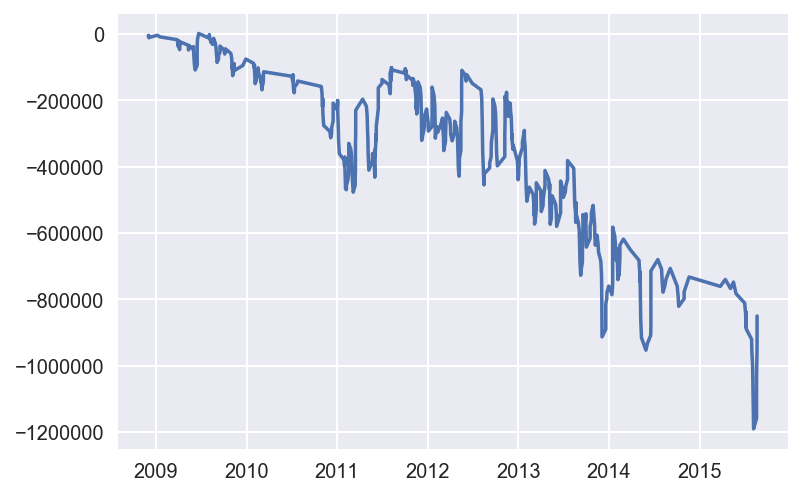

In [16]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

To run the backtest monthly, use the boolean parameter *monthly* on the *run* method (False by default).

In [17]:
# Short ATM straddle (monthly)
short_straddle_monthly = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.SELL)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg1.exit_filter = (schema.dte <= 60)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte > 60) & (schema.dte <= 90) & (schema.strike >= schema.underlying_last * 0.95) & (schema.strike <= schema.underlying_last * 1.05)

leg2.exit_filter = (schema.dte <= 60)

short_straddle_monthly.add_legs([leg1, leg2])
# Exit thresholds: none
short_straddle_monthly.exit_thresholds = (float('inf'), float('inf'))

In [18]:
bt = Backtest(capital = 0)
bt.strategy = short_straddle_monthly
bt.data = data
bt.stop_if_broke = False

In [19]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


leg_1                                               \
               contract underlying expiration  type  strike     cost   
0    SXY070217C01345000        SPX 2007-02-17  call  1345.0  -8530.0   
1    SXY070217C01345000        SPX 2007-02-17  call  1345.0   8200.0   
2    SXY070317C01355000        SPX 2007-03-17  call  1355.0  -7920.0   
3    SXY070317C01355000        SPX 2007-03-17  call  1355.0   9860.0   
4    SXZ070421C01485000        SPX 2007-04-21  call  1485.0  -1140.0   
..                  ...        ...        ...   ...     ...      ...   
154  SPX150821C02010000        SPX 2015-08-21  call  2010.0 -11900.0   
155  SPX150821C02010000        SPX 2015-08-21  call  2010.0   8940.0   
156  SPX150918C01975000        SPX 2015-09-18  call  1975.0 -12230.0   
157  SPX150918C01975000        SPX 2015-09-18  call  1975.0  12720.0   
158  SPX151016C02000000        SPX 2015-10-16  call  2000.0 -11020.0   

                                   leg_2                                     \
          date order            contract underlying expiration type  strike   
0   2006-12-06   STO  SXY070217P01345000        SPX 2007-02-17  put  1345.0   
1   2007-01-03   BTC  SXY070217P01345000        SPX 2007-02-17  put  1345.0   
2   2007-01-03   STO  SXY070317P01355000        SPX 2007-03-17  put  1355.0   
3   2007-02-01   BTC  SXY070317P01355000        SPX 2007-03-17  put  1355.0   
4   2007-02-01   STO  SXY070421P01375000        SPX 2007-04-21  put  1375.0   
..         ...   ...                 ...        ...        ...  ...     ...   
154 2015-06-01   STO  SPX150821P02010000        SPX 2015-08-21  put  2010.0   
155 2015-07-01   BTC  SPX150821P02010000        SPX 2015-08-21  put  2010.0   
156 2015-07-01   STO  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
157 2015-08-03   BTC  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
158 2015-08-03   STO  SPX151016P02000000        SPX 2015-10-16  put  2000.0   

                               totals  
       cost       date order     cost  
0    -790.0 2006-12-06   STO  -9320.0  
1     540.0 2007-01-03   BTC   8740.0  
2   -1030.0 2007-01-03   STO  -8950.0  
3     280.0 2007-02-01   BTC  10140.0  
4    -690.0 2007-02-01   STO  -1830.0  
..      ...        ...   ...      ...  
154 -2440.0 2015-06-01   STO -14340.0  
155  2650.0 2015-07-01   BTC  11590.0  
156 -3720.0 2015-07-01   STO -15950.0  
157  1560.0 2015-08-03   BTC  14280.0  
158 -2160.0 2015-08-03   STO -13180.0  

[159 rows x 17 columns]

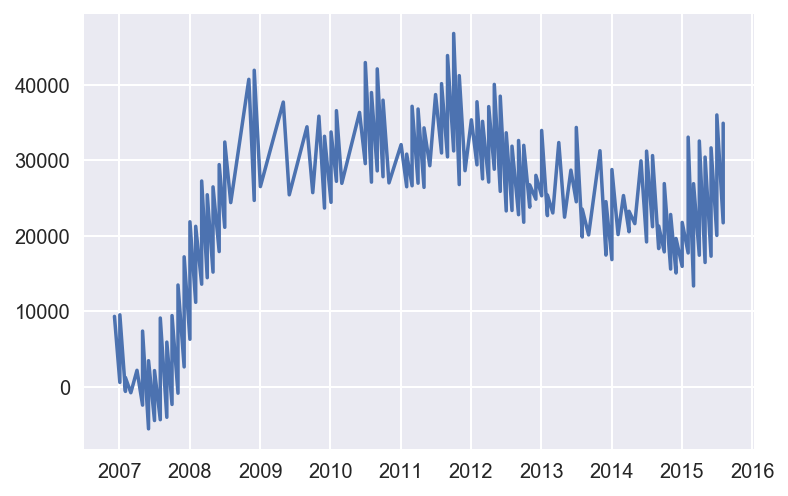

In [20]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);

We also have a class that parametrizes the straddle (long or short).

In [21]:
from backtester.strategy import Straddle

In [22]:
std = Straddle(schema, 'long', 'SPX', dte_entry_range=(61,90), dte_exit=60, atm_pct=(0.05, 0.05), exit_thresholds=(float('inf'), float('inf')))

*atm_pct* is the distance between the strike and the spot in percentage. For instance (0.05, 0.05) means we pick contracts for which the strike is within 5% of the spot price.

In [23]:
bt = Backtest(capital = 0)
bt.strategy = std
bt.data = data
bt.stop_if_broke = False

In [24]:
bt.run(monthly=True)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:00:09


leg_1                                               \
               contract underlying expiration  type  strike     cost   
0    SXY070217C01345000        SPX 2007-02-17  call  1345.0   8710.0   
1    SXY070217C01345000        SPX 2007-02-17  call  1345.0  -8000.0   
2    SXY070317C01355000        SPX 2007-03-17  call  1355.0   8120.0   
3    SXY070317C01355000        SPX 2007-03-17  call  1355.0  -9660.0   
4    SXZ070421C01485000        SPX 2007-04-21  call  1485.0   1300.0   
..                  ...        ...        ...   ...     ...      ...   
154  SPX150821C02010000        SPX 2015-08-21  call  2010.0  12220.0   
155  SPX150821C02010000        SPX 2015-08-21  call  2010.0  -8640.0   
156  SPX150918C01975000        SPX 2015-09-18  call  1975.0  12530.0   
157  SPX150918C01975000        SPX 2015-09-18  call  1975.0 -12330.0   
158  SPX151016C02000000        SPX 2015-10-16  call  2000.0  11360.0   

                                   leg_2                                     \
          date order            contract underlying expiration type  strike   
0   2006-12-06   BTO  SXY070217P01345000        SPX 2007-02-17  put  1345.0   
1   2007-01-03   STC  SXY070217P01345000        SPX 2007-02-17  put  1345.0   
2   2007-01-03   BTO  SXY070317P01355000        SPX 2007-03-17  put  1355.0   
3   2007-02-01   STC  SXY070317P01355000        SPX 2007-03-17  put  1355.0   
4   2007-02-01   BTO  SXY070421P01375000        SPX 2007-04-21  put  1375.0   
..         ...   ...                 ...        ...        ...  ...     ...   
154 2015-06-01   BTO  SPX150821P02010000        SPX 2015-08-21  put  2010.0   
155 2015-07-01   STC  SPX150821P02010000        SPX 2015-08-21  put  2010.0   
156 2015-07-01   BTO  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
157 2015-08-03   STC  SPX150918P02015000        SPX 2015-09-18  put  2015.0   
158 2015-08-03   BTO  SPX151016P02000000        SPX 2015-10-16  put  2000.0   

                               totals  
       cost       date order     cost  
0     880.0 2006-12-06   BTO   9590.0  
1    -460.0 2007-01-03   STC  -8460.0  
2    1190.0 2007-01-03   BTO   9310.0  
3    -200.0 2007-02-01   STC  -9860.0  
4     750.0 2007-02-01   BTO   2050.0  
..      ...        ...   ...      ...  
154  2670.0 2015-06-01   BTO  14890.0  
155 -2470.0 2015-07-01   STC -11110.0  
156  3980.0 2015-07-01   BTO  16510.0  
157 -1390.0 2015-08-03   STC -13720.0  
158  2360.0 2015-08-03   BTO  13720.0  

[159 rows x 17 columns]

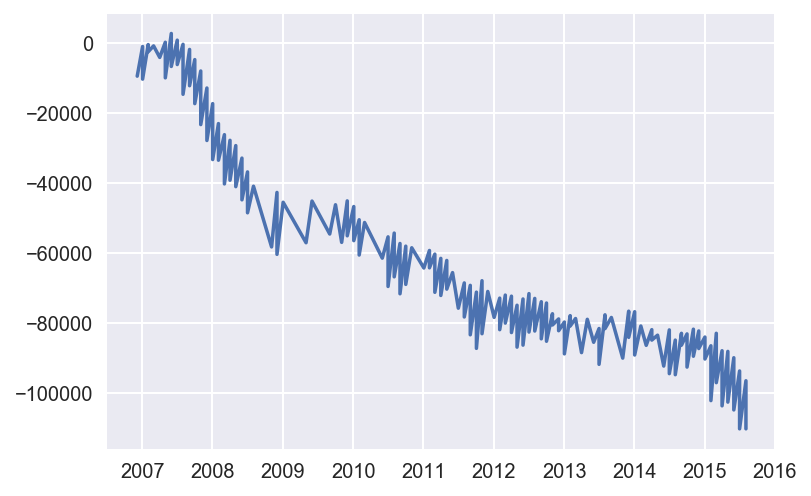

In [25]:
capital = (-bt.trade_log['totals']['cost']).cumsum()
date = bt.trade_log['leg_1']['date']
plt.plot(date, capital);